In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
#from anndata import AnnData
import scipy
#from numpy.linalg import svd


import warnings
warnings.filterwarnings("ignore")


In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), './'))
    
    #from pcNet import pcNet
    from main import *
    #import dNN 
    #from neighborhood import laplacian #for eigendecomp
except ImportError:
    print('Module not found')

In [3]:
ada = sc.read_h5ad("data/LS.h5ad")
ada

AnnData object with n_obs × n_vars = 5011 × 17328
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [4]:
data = scipy.sparse.csr_matrix.toarray(ada.X)
counts = np.asarray(np.expm1(data), dtype=int)
ada.layers['raw'] = counts
ada.layers['log1p'] = data

In [5]:
HVG_i = np.argsort(np.asarray(ada.var['vst.variance.standardized']))[-3000:]
ada = ada[:, HVG_i].copy()
ada

AnnData object with n_obs × n_vars = 5011 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    layers: 'raw', 'log1p'

## create a Xct_metrics obj

In [6]:
skin = Xct_metrics(ada)
type(skin)

main.Xct_metrics

In [7]:
skin.DB.head()

,ligand,receptor
0,BDNF,TRPC1
1,CXCL12,GNAI2
2,PF4,GNAI2
3,EPOR,TRPC3
4,EPOR,EPO


In [8]:
skin._genes_index_DB

array([[1194,    0],
       [2920,    0],
       [   0,    0],
       ...,
       [   0,    0],
       [   0,    0],
       [   0,    0]])

In [9]:
ada.var_names[1194-1]

'BDNF'

918 (intervals for fit) / 3000 (filtered -Inf) / 3000 (original) features for the fit


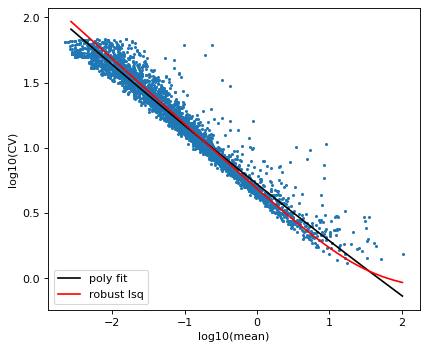

array([ 0.048889  , -0.07626458, -0.02784309, ...,  0.78019458,
        0.59314723,  0.22144539])

In [10]:
skin.chen2016_fit(ada, plot = True, verbose = True)

## create a Xct obj with GRN building:

In [11]:
obj1 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = True, mode = 'pairs', pcNet_path = './data')
df1 = obj1.fill_metric()
df1

,ligand,receptor,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
21,IGF1,NTRK2,0.029522,0.024446,0.067410,0.027285,2.283343,1.116142,8.794479,6.757026,0.156436,-0.338065
31,AREG,NTRK2,0.003443,0.024446,0.005726,0.027285,1.663072,1.116142,21.977261,6.757026,-0.221117,-0.338065
36,FGF2,NTRK2,0.076530,0.024446,0.142827,0.027285,1.866276,1.116142,4.938230,6.757026,-0.075862,-0.338065
38,FGF7,NTRK2,0.449156,0.024446,0.835224,0.027285,1.859543,1.116142,2.034720,6.757026,0.023099,-0.338065
56,BDNF,NTRK2,0.009386,0.024446,0.016305,0.027285,1.737234,1.116142,13.604940,6.757026,-0.094830,-0.338065
...,...,...,...,...,...,...,...,...,...,...,...,...
7974,LAMB1,SV2B,0.192922,0.015761,0.356617,0.019873,1.848509,1.260899,3.095425,8.944272,-0.019347,-0.338065
7980,LAMC3,SV2B,0.343355,0.015761,0.610706,0.019873,1.778645,1.260899,2.276004,8.944272,-0.046932,-0.338065
7984,LAMB2,SV2B,1.027162,0.015761,1.343443,0.019873,1.307918,1.260899,1.128420,8.944272,-0.030466,-0.338065
8113,FSTL1,DIP2A,1.154967,0.066773,1.490066,0.086209,1.290138,1.291068,1.056898,4.397163,0.014484,-0.313400


## permutation mode:

In [12]:
np.random.seed(1)

orig_score0 = np.asarray(obj1.score(method=0))
pmt_scores0 = scores(ada, obj1, n=100)

enriched, pvals, counts = pmt_test(orig_score0, pmt_scores0)
#enriched, counts

df_enriched = df1.iloc[enriched, :]
print(len(df_enriched))
df_enriched

54


,ligand,receptor,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
1391,CTGF,ITGB2,0.486820,0.790692,0.944553,1.052845,1.940253,1.331549,1.996389,1.297701,0.087534,-0.062784
1395,VCAM1,ITGB2,1.027157,0.790692,1.538420,1.052845,1.497745,1.331549,1.207537,1.297701,0.042033,-0.062784
1405,CYR61,ITGB2,0.409883,0.790692,0.827932,1.052845,2.019924,1.331549,2.219921,1.297701,0.092586,-0.062784
1804,NRG2,NRG1,0.017905,0.024133,0.040777,0.026448,2.277441,1.095898,11.278239,6.738711,0.004129,-0.338065
3716,FGF2,DDR1,0.076530,0.030671,0.142827,0.047213,1.866276,1.539335,4.938230,7.084414,-0.075862,-0.139486
3736,BDNF,DDR1,0.009386,0.030671,0.016305,0.047213,1.737234,1.539335,13.604940,7.084414,-0.094830,-0.139486
4185,CCL2,VEGFA,1.328773,0.264259,2.754422,0.576541,2.072906,2.181724,1.249005,2.873324,0.377418,0.190714
4197,BMP4,VEGFA,0.247091,0.264259,0.480821,0.576541,1.945927,2.181724,2.806304,2.873324,-0.014840,0.190714
4682,CCL2,TNF,1.328773,0.422778,2.754422,0.808993,2.072906,1.913517,1.249005,2.127453,0.377418,0.247246
4705,STC1,TNF,0.044813,0.422778,0.101409,0.808993,2.262904,1.913517,7.106056,2.127453,0.048059,0.247246


## mode 'pairs':

In [13]:
obj1._net_A.shape, obj1._net_B.shape, obj1._w.shape

((3000, 3000), (3000, 3000), (6000, 6000))

In [14]:
#selected LR pairs
candidates = obj1._candidates(df1)
print(len(candidates))
candidates[:5]

160


['IGF1_NTRK2', 'AREG_NTRK2', 'FGF2_NTRK2', 'FGF7_NTRK2', 'BDNF_NTRK2']

Net(
  (linear1): Linear(in_features=484, out_features=124, bias=True)
  (linear2): Linear(in_features=124, out_features=31, bias=True)
  (linear3): Linear(in_features=31, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
0 4572.1328125
99 340.266357421875
199 246.72662353515625
299 154.23776245117188
399 137.03350830078125
499 149.54837036132812
599 111.4591293334961
699 112.34220123291016
799 99.17721557617188
899 93.65138244628906
999 90.7223129272461
1099 87.95536041259766
1199 88.56504821777344
1299 84.5805435180664
1399 86.79930114746094
1499 82.60209655761719
1599 85.28280639648438
1699 82.1225357055664
1799 81.36642456054688
1899 84.50813293457031
1999 79.22510528564453
2099 76.7509994506836
2199 77.23727416992188
2299 76.22310638427734
2399 75.45735168457031
2499 75.3785171508789
2599 77.62641143798828


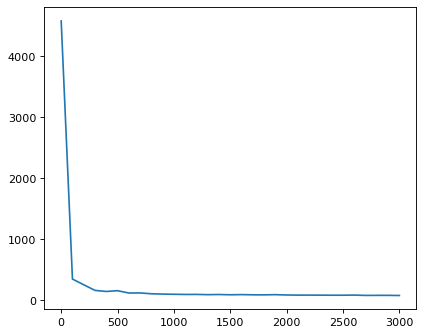

In [15]:
projections, losses = obj1.nn_projection(plot_loss = True)

In [18]:
df_nn = obj1.nn_output(projections)
df_nn.head()

,idx,dist,rank,correspondence_score
DCN_CD74,"(2992, 2991)",0.000021,0,252680.387982
DCN_HLA-DPA1,"(2992, 2987)",0.000023,1,151729.067963
DCN_HLA-DPB1,"(2992, 2983)",0.000034,2,150459.787379
COL6A3_CD74,"(2819, 2991)",0.000035,3,222090.297180
COL6A3_HLA-DPA1,"(2819, 2987)",0.000038,4,133360.384887


In [25]:
df_nn_to_output = df_nn.iloc[:1000, :]
df_nn_to_output.to_csv('distances_nn.csv')

[[ 1.         -0.19558931]
 [-0.19558931  1.        ]]


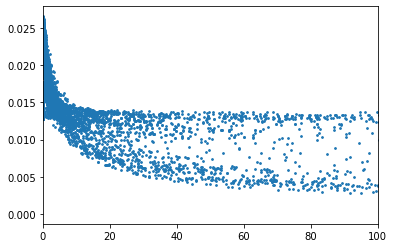

In [19]:
#check corr
select = df_nn['correspondence_score'] != 0
nX = np.asarray(df_nn['correspondence_score'][select])
nY = np.asarray(df_nn['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [20]:
#distance rank of L-R candidates
i = 0 
for p in candidates:
    if df_nn.loc[p].values[2] < 200: #rank < ?
        i += 1
        print(p, "idx, dist, rank, score, rank%:", ' '.join(map(str, df_nn.loc[p].values)), f'{round(100* df_nn.loc[p].values[2]/len(df_nn), 5)}%')

print('\nTotal enriched:', i)

CCL2_CXCR4 idx, dist, rank, score, rank%: (2820, 2548) 0.0003134064609184861 117 10099.652056687146 0.0013%
CXCL12_CXCR4 idx, dist, rank, score, rank%: (2919, 2548) 0.00030938672716729343 115 10632.471403626823 0.00128%
CCL19_CXCR4 idx, dist, rank, score, rank%: (2993, 2548) 0.00024062632292043418 86 19128.18971225585 0.00096%
CXCL14_CXCR4 idx, dist, rank, score, rank%: (2994, 2548) 0.0002450774481985718 87 18813.953918820935 0.00097%
CCL2_CCR7 idx, dist, rank, score, rank%: (2820, 2138) 0.0002631390234455466 91 14432.605620118067 0.00101%
CXCL12_CCR7 idx, dist, rank, score, rank%: (2919, 2138) 0.00025837711291387677 90 15194.015167495256 0.001%
CCL19_CCR7 idx, dist, rank, score, rank%: (2993, 2138) 0.0001909513957798481 63 27334.567249868593 0.0007%
CXCL14_CCR7 idx, dist, rank, score, rank%: (2994, 2138) 0.00019314896780997515 65 26885.517990258882 0.00072%

Total enriched: 8


## mode 'combinators'

In [21]:
obj2 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = True, mode = 'combinators', pcNet_path = './data')

Net(
  (linear1): Linear(in_features=484, out_features=124, bias=True)
  (linear2): Linear(in_features=124, out_features=31, bias=True)
  (linear3): Linear(in_features=31, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
0 4698.8232421875
99 401.41064453125
199 326.4110412597656
299 240.31919860839844
399 180.10360717773438
499 162.25140380859375
599 150.72158813476562
699 151.59156799316406
799 137.11585998535156
899 177.75701904296875
999 133.3683319091797
1099 138.2772979736328
1199 119.08071899414062
1299 122.50074768066406
1399 117.90138244628906
1499 117.79954528808594
1599 119.0386962890625
1699 110.22612762451172
1799 109.7271957397461
1899 111.82891845703125
1999 106.54006958007812
2099 104.398681640625
2199 106.44234466552734
2299 103.08409118652344
2399 102.34733581542969
2499 99.43623352050781
2599 

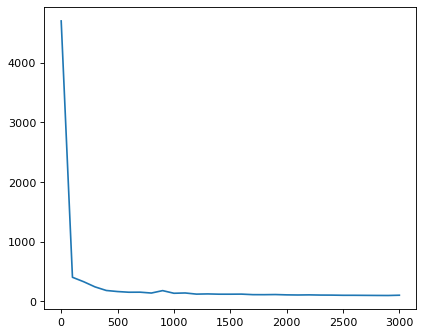

In [22]:
projections2, losses2 = obj2.nn_projection(plot_loss = True)

In [23]:
df_nn2 = obj2.nn_output(projections2)
df_nn2.head()

,idx,dist,rank,correspondence_score
DCN_HLA-DPB1,"(2992, 2983)",0.000439,0,113545.711532
DCN_HLA-DPA1,"(2992, 2987)",0.000444,1,114503.584525
DCN_CD74,"(2992, 2991)",0.000457,2,190687.325452
COL6A3_HLA-DPB1,"(2819, 2983)",0.000460,3,99799.596712
COL6A3_HLA-DPA1,"(2819, 2987)",0.000466,4,100641.507315


[[ 1.         -0.17686447]
 [-0.17686447  1.        ]]


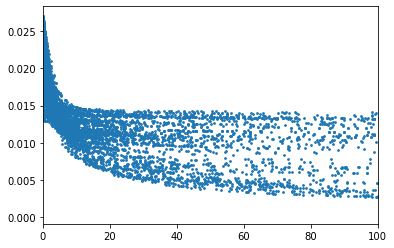

In [24]:
#check corr
select = df_nn2['correspondence_score'] != 0
nX = np.asarray(df_nn2['correspondence_score'][select])
nY = np.asarray(df_nn2['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
df_nn_to_output2 = df_nn2.iloc[:1000, :]
df_nn_to_output2.to_csv('distances_nn2.csv')

In [26]:
#candidates = obj2._LR_candidates(df1)

#distance rank of L-R candidates
i = 0 
for p in candidates:
    if df_nn2.loc[p].values[2] < 200: #rank < ?
        i += 1
        print(p, "idx, dist, rank, score, rank%:", ' '.join(map(str, df_nn2.loc[p].values)), f'{round(100* df_nn2.loc[p].values[2]/len(df_nn2), 5)}%')

print('\nTotal enriched:', i)

CCL2_CXCR4 idx, dist, rank, score, rank%: (2820, 2548) 0.0006897841230966151 146 7621.785189064844 0.00162%
CXCL12_CXCR4 idx, dist, rank, score, rank%: (2919, 2548) 0.0006837776745669544 142 8023.881675573323 0.00158%
CCL19_CXCR4 idx, dist, rank, score, rank%: (2993, 2548) 0.0005793552845716476 50 14435.245117772507 0.00056%
CXCL14_CXCR4 idx, dist, rank, score, rank%: (2994, 2548) 0.0005849227891303599 53 14198.10450116181 0.00059%
CCL2_CCR7 idx, dist, rank, score, rank%: (2820, 2138) 0.0006584888324141502 119 10891.684103334594 0.00132%
CXCL12_CCR7 idx, dist, rank, score, rank%: (2919, 2138) 0.0006521482719108462 115 11466.288057850983 0.00128%
CCL19_CCR7 idx, dist, rank, score, rank%: (2993, 2138) 0.0005477624945342541 30 20628.25517603859 0.00033%
CXCL14_CCR7 idx, dist, rank, score, rank%: (2994, 2138) 0.000553401536308229 35 20289.376472411597 0.00039%

Total enriched: 8


## mode None (use all):

In [27]:
obj3 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = True, mode = None, pcNet_path = './data')

Net(
  (linear1): Linear(in_features=484, out_features=124, bias=True)
  (linear2): Linear(in_features=124, out_features=31, bias=True)
  (linear3): Linear(in_features=31, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
0 5188.46533203125
99 710.5101318359375
199 632.9097900390625
299 590.5418090820312
399 566.173095703125
499 553.3591918945312
599 546.3666381835938
699 542.36572265625
799 539.9539184570312
899 538.40771484375
999 537.3521728515625
1099 536.6038818359375
1199 536.0637817382812
1299 535.6533813476562
1399 535.3528442382812
1499 535.1118774414062
1599 534.9122314453125
1699 534.757080078125
1799 534.643798828125
1899 534.5408325195312
1999 534.4583129882812
2099 534.3782348632812
2199 534.3267822265625
2299 534.2742919921875
2399 534.2295532226562
2499 534.184814453125
2599 534.15087890625
2699 

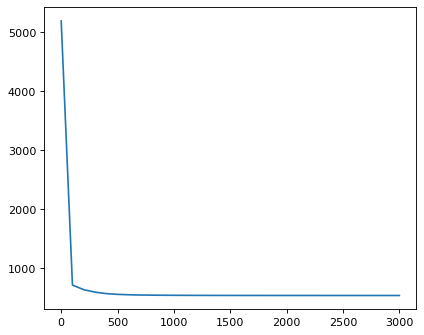

In [28]:
projections3, losses3 = obj3.nn_projection(plot_loss = True)

In [29]:
df_nn3 = obj3.nn_output(projections3)
df_nn3.head()

,idx,dist,rank,correspondence_score
FOS_CD1B,"(2946, 2516)",0.000003,0,140.040865
C3_TXNIP,"(2880, 744)",0.000003,1,169.704870
TIMP2_ZFP36,"(1102, 2517)",0.000004,2,138.106644
COMP_DNAJB1,"(2965, 2381)",0.000004,3,120.706764
ID2_HLA-DPA1,"(2330, 2987)",0.000005,4,354.556896


[[ 1.        -0.1452785]
 [-0.1452785  1.       ]]


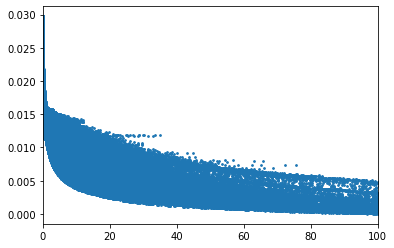

In [30]:
#check corr
select = df_nn3['correspondence_score'] != 0
nX = np.asarray(df_nn3['correspondence_score'][select])
nY = np.asarray(df_nn3['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [31]:
df_nn_to_output3 = df_nn3.iloc[:20000, :]
df_nn_to_output3.to_csv('distances_nn3.csv')

In [32]:
#candidates = obj3._LR_candidates(df1)

#distance rank of L-R candidates
i = 0 
for p in candidates:
    if df_nn3.loc[p].values[2] < 15000: #rank < ?
        i += 1
        print(p, "idx, dist, rank, score, rank%:", ' '.join(map(str, df_nn3.loc[p].values)), f'{round(100* df_nn3.loc[p].values[2]/len(df_nn3), 5)}%')

print('\nTotal enriched:', i)

VCAM1_ITGB2 idx, dist, rank, score, rank%: (1458, 491) 0.0008403239771723747 10718 61.91220432280544 0.11909%
CCL2_CXCR4 idx, dist, rank, score, rank%: (2820, 2548) 0.0005963276489637792 7630 215.66252404186545 0.08478%
CXCL12_CXCR4 idx, dist, rank, score, rank%: (2919, 2548) 0.0006354495417326689 8162 227.04006106733814 0.09069%
CCL19_CXCR4 idx, dist, rank, score, rank%: (2993, 2548) 0.0009207729599438608 11666 408.4530487330359 0.12962%
CXCL14_CXCR4 idx, dist, rank, score, rank%: (2994, 2548) 0.0009031611261889338 11479 401.7430270435658 0.12754%
CCL2_CCR7 idx, dist, rank, score, rank%: (2820, 2138) 0.0007617631927132607 9697 308.1860780020229 0.10774%
CXCL12_CCR7 idx, dist, rank, score, rank%: (2919, 2138) 0.0008016705396585166 10211 324.444806906274 0.11346%
CCL19_CCR7 idx, dist, rank, score, rank%: (2993, 2138) 0.0010861551854759455 13667 583.6876095939929 0.15186%
CXCL1_CCR7 idx, dist, rank, score, rank%: (2596, 2138) 0.001149571966379881 14440 70.73035710905451 0.16044%
CXCL14_C